     Position  Velocity  Smoothing_Length Pressure Density Acceleration  \
0       -0.10 -0.000059             0.012      NaN     NaN          NaN   
1       -0.09 -0.000054             0.012      NaN     NaN          NaN   
2       -0.08 -0.000048             0.012      NaN     NaN          NaN   
3       -0.07 -0.000043             0.012      NaN     NaN          NaN   
4       -0.06 -0.000037             0.012      NaN     NaN          NaN   
..        ...       ...               ...      ...     ...          ...   
115      1.05  0.000031             0.012      NaN     NaN          NaN   
116      1.06  0.000037             0.012      NaN     NaN          NaN   
117      1.07  0.000043             0.012      NaN     NaN          NaN   
118      1.08  0.000048             0.012      NaN     NaN          NaN   
119      1.09  0.000054             0.012      NaN     NaN          NaN   

    Acceleration0  Is_Ghost  
0             NaN      True  
1             NaN      True  
2        

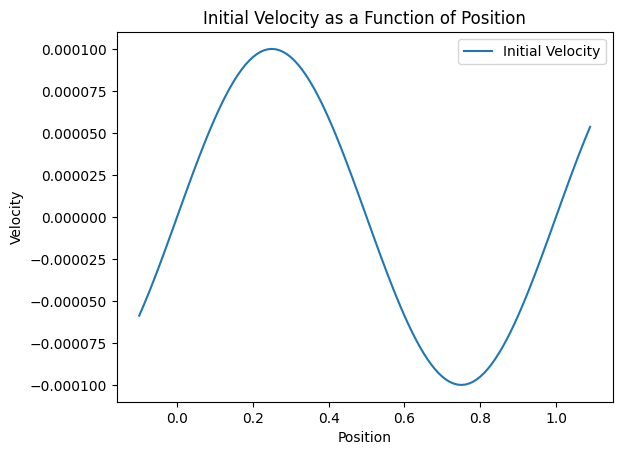

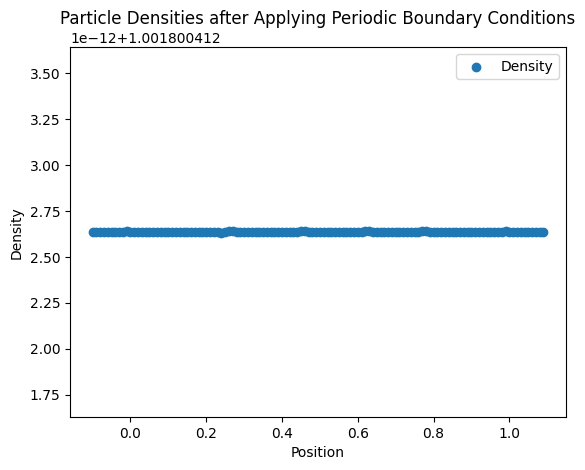

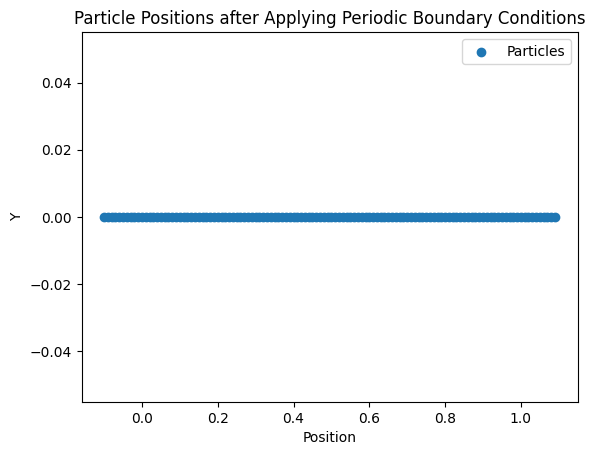

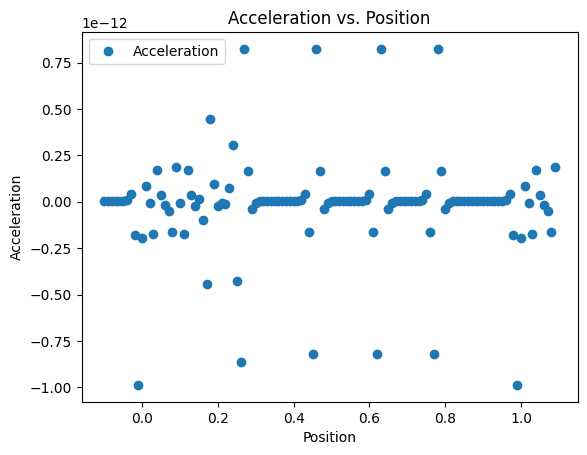

CFL condition satisfied, proceeding with timestepping
     Position  Velocity  Smoothing_Length  Pressure   Density  Acceleration  \
0   -0.100003 -0.000056             0.012  1.001774  1.001774      0.000125   
1   -0.090003 -0.000051             0.012  1.001773  1.001773      0.000114   
2   -0.080002 -0.000046             0.012  1.001772  1.001772      0.000102   
3   -0.070002 -0.000040             0.012  1.001771  1.001771      0.000091   
4   -0.060002 -0.000035             0.012  1.001771  1.001771      0.000078   
..        ...       ...               ...       ...       ...           ...   
115  1.050002  0.000029             0.012  1.001770  1.001770     -0.000066   
116  1.060002  0.000035             0.012  1.001771  1.001771     -0.000078   
117  1.070002  0.000040             0.012  1.001771  1.001771     -0.000091   
118  1.080002  0.000046             0.012  1.001772  1.001772     -0.000102   
119  1.090003  0.000051             0.012  1.001773  1.001773     -0.000114  

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from particle_system_pandas import SPHParticles
from density_pandas import get_density, get_accel
from equation_of_state_pandas import equation_of_state
from output_pandas import output_particles
import boundary_conditions_pandas as bc
import output_pandas as output
from derivs import derivs
from timestepping import leapfrog_integration
from cfl_condition import compute_cfl_time_step

def main():
    start_time = time.time()
    current_time = 0.0

    #Initialize a bunch of stuff 
    
    #Simulation parameters
    sound_speed = 1.0
    n_particles = 100
    num_neighbors = 10
    xmin_value = 0.0
    xmax_value = 1.0
    rho_0_value = 1.0
    print_ghost_particles = False
    
    #Output related
    output_filename = "sph_initial.txt"
    tout = 0.05  # Specify the time between output files here
    next_output_time = tout
    output_index = 1

    total_particles = n_particles + 2 * num_neighbors
    particles = SPHParticles(total_particles)

    particles.setup(xmin_value, xmax_value, rho_0_value, num_neighbors, sound_speed)

    #since mass of particles is dictated by rho_0 and number of particles, it is not here as an input value but it is same for all particles
    mass = particles.mass
    
    output_particles(particles.to_dataframe(), output_filename, include_ghosts=print_ghost_particles)

    data = pd.read_csv(output_filename)

    output.print_header()
    
    plt.plot(particles.data['Position'], particles.data['Velocity'], label='Initial Velocity')
    plt.title('Initial Velocity as a Function of Position')
    plt.xlabel('Position')
    plt.ylabel('Velocity')
    plt.legend()
    plt.show()

    particles = derivs(particles, mass, num_neighbors, sound_speed)

    plt.scatter(particles.data['Position'], particles.data['Density'], label='Density')
    plt.title('Particle Densities after Applying Periodic Boundary Conditions')
    plt.xlabel('Position')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    plt.scatter(particles.data['Position'], [0] * len(particles.data['Position']), label='Particles')
    plt.title('Particle Positions after Applying Periodic Boundary Conditions')
    plt.xlabel('Position')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

    plt.plot(particles.data['Position'], particles.data['Acceleration'], 'o', label='Acceleration')
    plt.xlabel('Position')
    plt.ylabel('Acceleration')
    plt.title('Acceleration vs. Position')
    plt.legend()
    plt.show()

    #print("Length of df", len(particles.data['Position']))
    #print(particles.data['Acceleration'].tolist())

    # Initialize parameters for CFL condition
    C = 0.3  # Adjust as needed
    h = particles.data['Smoothing_Length']  # Assuming you have a method to get the smoothing length
    vmax = np.max(np.abs(particles.data['Velocity']))  # Maximum velocity in the domain
    csmax = sound_speed 
    
    dt = 0.003  # Check for this timestep with Bec
    end_simulation_time = 5.0  # adjust this value for the total simulation time

    max_files = int(end_simulation_time / tout) + 1
    padding_width = len(str(max_files))

    cfl_dt = compute_cfl_time_step(C, h, vmax, csmax).iloc[0]
    if dt > cfl_dt:
        raise ValueError(f"Time step dt = {dt} violates CFL condition. Adjust simulation parameters or decrease dt. The CFL condition requires dt < {cfl_dt}")
    if dt <= cfl_dt:
        print("CFL condition satisfied, proceeding with timestepping")
            
    while current_time < end_simulation_time:
        
        leapfrog_integration(particles, dt, mass, num_neighbors, sound_speed)
        current_time += dt

        if current_time >= next_output_time:
            output_filename = f"sph_finalsim{output_index:0{padding_width}d}.txt"
            output_particles(particles.to_dataframe(), output_filename, include_ghosts=print_ghost_particles)
            output_index += 1
            next_output_time += tout
            
    end_time = time.time()
    output.print_execution_time(start_time, end_time)

if __name__ == "__main__":
    main()
